In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random
import numpy as np
import pandas as pd
import torch
np.random.seed(0)
random.seed(0)

In [ ]:
#Core libraries
import torch
import numpy as np
import pandas as pd
import gpytorch

#Ax library
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.datasets import SupervisedDataset
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood, LeaveOneOutPseudoLikelihood, SumMarginalLogLikelihood
from gpytorch.mlls import VariationalELBO
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition import qNoisyExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement, LogProbabilityOfImprovement
from ax.service.ax_client import AxClient, ObjectiveProperties
from botorch.models.gp_regression import FixedNoiseGP

#Deveper API
from ax import (
    ComparisonOp,
    ParameterType,
    RangeParameter,
    ChoiceParameter,
    FixedParameter,
    SearchSpace,
    Experiment,
    OutcomeConstraint,
    OrderConstraint,
    SumConstraint,
    OptimizationConfig,
    Objective,
    Metric,
    Runner,
    Data,
    Arm,
)
from ax.core import ObservationFeatures
#For Visualization Purposes
from ax.utils.notebook.plotting import render
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.slice import plot_slice



## Get Data

In [5]:
#get modified features and train_final label from the csv file
# NAME_OF_FILE = 'modified_features.csv'
NAME_OF_FILE =  'Data/modified_featuresforBOwpreQY_corrected.csv'
NAME_OF_FILE_GPR = '/Users/jorgemedina/DOEFinal/DOE/AgML/Data/modified_featuresforBO_corrected_onlyJ.csv'
mod_dataset = pd.read_csv(NAME_OF_FILE, index_col=0)
modified_features = mod_dataset.iloc[:,0:9] #the first ones are the features, the last one is the label
train_final_label = mod_dataset.iloc[:,10]
#transform to torch
train_final_label_pt = torch.tensor(train_final_label.values, dtype=torch.float)
modified_features_pt = torch.tensor(modified_features.values, dtype=torch.float)

print("You have a total of ", len(modified_features), " data points")
print("With ", len(modified_features.columns), " number of features each")
#print(" and ", len() , " label(s) each") # In theory you could want to do multi-objective optimization

#get the first 50 data points to train the model
train_x = modified_features_pt[:50]


############################################################################################################

modified_features.head() # What are the columns? That might be good to have it in the .csv file

You have a total of  70  data points
With  10  number of features each


,0,1,2,3,4,5,6,7,8,9
0,18.8,14.04,0.175,0.25,0.0060,7.8,1.25,60.0,25,0.405553
1,18.8,14.04,0.175,0.25,0.0060,7.8,2.50,60.0,25,0.405553
2,18.8,14.04,0.175,0.25,0.0060,7.8,5.00,60.0,25,0.405553
3,18.8,14.04,0.175,0.25,0.0060,7.8,10.00,60.0,25,0.405553
4,18.8,14.04,0.175,0.25,0.0007,3.5,0.25,60.0,25,0.405553


## Define your models with GPyTorch-BoTorch

Text(0.5, 0, 'Trial')

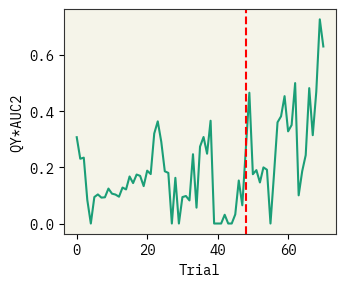

In [6]:
#make a plot of f vs trial
import matplotlib.pyplot as plt
plt.plot(train_final_label)
#add a vertical line at trial 49
plt.axvline(x=48, color='r', linestyle='--')
plt.ylabel('QY*AUC2')
plt.xlabel('Trial')


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

You have a total of  65  data points
With  9  number of features each
You have a total of  65  data points
With  9  number of features each
[3.07496970e-01 2.30742619e-01 2.34684107e-01 8.38879571e-02
 4.92881452e-08 9.42982443e-02 1.03654015e-01 9.22627459e-02
 9.34143199e-02 1.24480295e-01 1.06450998e-01 1.03100328e-01
 9.54507535e-02 1.28165598e-01 1.21407889e-01 1.67580554e-01
 1.44038875e-01 1.74468493e-01 1.69743032e-01 1.33224468e-01
 1.88305054e-01 1.76120614e-01 3.20538401e-01 3.63978916e-01
 2.91011751e-01 1.86055683e-01 1.80357236e-01 1.12833506e-08
 1.62788692e-01 1.12656084e-08 9.41715779e-02 9.79803656e-02
 8.22179125e-02 2.46886664e-01 5.65085035e-02 2.73843033e-01
 3.08192770e-01 2.48769315e-01 3.66135998e-01 6.00843240e-09
 5.37608234e-23 3.60971019e-23 3.11985015e-02 1.25092534e-23
 2.63425864e-23 3.23517737e-02 1.53250921e-01 6.49503127e-02
 4.65995851e-01 1.75614846e-01 1.90240699e-01 1.46220986e-01
 1.99923407e-01 1.91591800e-01 1.53554262e-20 1.75761917e-01
 3.605

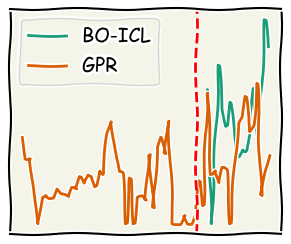

In [11]:

NAME_OF_FILE_GPR = '/Users/jorgemedina/DOEFinal/DOE/AgML/Data/modified_featuresforBO_corrected_onlyJ.csv'
mod_dataset_only_J = pd.read_csv(NAME_OF_FILE_GPR, index_col=0)
modified_features_onlyj = mod_dataset_only_J.iloc[:,0:9] #the first ones are the features, the last one is the label
train_final_label_onlyj = mod_dataset_only_J.iloc[:,9]
#transform to torch
train_final_label_pt_onlyj = torch.tensor(train_final_label_onlyj.values, dtype=torch.float)
modified_features_pt_onlyj = torch.tensor(modified_features_onlyj.values, dtype=torch.float)

print("You have a total of ", len(modified_features_onlyj), " data points")
print("With ", len(modified_features_onlyj.columns), " number of features each")
#print(" and ", len() , " label(s) each") # In theory you could want to do multi-objective optimization

NAME_OF_FILE_NLP = '/Users/jorgemedina/DOEFinal/DOE/AgML/Data/modified_featuresforBO_corrected_onlyM.csv'
mod_dataset_only_NLP = pd.read_csv(NAME_OF_FILE_NLP, index_col=0)
modified_features_onlyNLP = mod_dataset_only_NLP.iloc[:,0:9] #the first ones are the features, the last one is the label
train_final_label_onlyNLP = mod_dataset_only_NLP.iloc[:,9]
#transform to torch
train_final_label_pt_onlyNLP = torch.tensor(train_final_label_onlyNLP.values, dtype=torch.float)
modified_features_pt_onlyNLP = torch.tensor(modified_features_onlyNLP.values, dtype=torch.float)

print("You have a total of ", len(modified_features_onlyNLP), " data points")
print("With ", len(modified_features_onlyNLP.columns), " number of features each")
#print(" and ", len() , " label(s) each") # In theory you could want to do multi-objective optimization


print(train_final_label_onlyj.to_numpy())
with plt.xkcd():
    plt.plot(train_final_label_onlyNLP.to_numpy(),label='BO-ICL')
    plt.plot(train_final_label_onlyj.to_numpy(),label='GPR')
    #add a vertical line at trial 49
    plt.axvline(x=45, color='r', linestyle='--')
    #remove ticks 
    plt.xticks([])
    plt.yticks([])

    plt.legend()
    plt.show()
############################################################################################################
# plt.plot(train_final_label_onlyj,label='GPR')
# plt.plot(train_final_label_onlyNLP,label='BO-ICL')
# #add a vertical line at trial 49
# plt.axvline(x=45, color='r', linestyle='--')
# plt.ylabel('QY*AUC2')
# plt.xlabel('Trial')
# plt.title("BO-ICL vs GPR")
# plt.legend()
# plt.show()


# modified_features.head() # What are the columns? That might be good to have it in the .csv file

In [ ]:
### This is how i figure base on a lot of conversation and trial and error that you can 
### initialize your model classes for use with Ax.dev framework. (e.g. speficying the likelihood directly in the __init__)
class ExactGPModel1(gpytorch.models.ExactGP, GPyTorchModel):
    
    _num_outputs = 1 

    def __init__(self, train_X, train_Y,**kwargs):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood(), **kwargs)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=9))
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#matern models

class BaseGPMatern(gpytorch.models.ExactGP, GPyTorchModel):
    _num_outputs = 1 
    
    def __init__(self, train_X, train_Y, **kwargs):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood(), **kwargs)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=9))
        self.to(train_X)
            
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

# Ax.dev ingredients
Either Service or Developer API work for our purposes. Choose the one you prefer, Developer gives more flexibility to the creation of the optimization loop

## Using the Service API

### Generation Strategy

In [8]:
# Because we already have a warm start with raw data, we dont need SOBOL sampling to begin with. So we want to use BoTorch w qExpectedImprovement for sampling
# the mll_class can be either ExactMarginalLogLikelihood or LeaveOneOutPseudoLikelihood for our ExactGP models. The later is more stable.
gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_gen_kwargs={"max_retries": 10},
            model_kwargs={
                "surrogate":Surrogate(BaseGPMatern, mll_class=LeaveOneOutPseudoLikelihood),
                
                "botorch_acqf_class": qExpectedImprovement,
                },
        ),
    ]
)

### SearchSpace


In [ ]:
## Points to consider
#for the "choice" variables, add ordered = False 
# as parameter if you prefer one-hot encoding rather than ordinal encoding
# for more options look at Ax documentation on parameters and Trasformations (Transforms)
ax_parameters = [
    {
        "name": "Dimension1",
        "type": "range",
        "bounds": [12.0000,51.00000],
        "value_type":'float'
    },
    {
        "name": "Dimension2",
        "type": "range",
        "bounds": [6,26],
        "value_type": 'float'
    },
    {
        "name": "Dilution(OD)",
        "type": "range",
        "bounds": [0.12,0.465]
    },
    {   "name":"Nano_stock_vol",
        "type":"choice",
        "values": [0.25,0.5],

    },
    {
        "name": "Ag_acet_conc",
        "type": "choice",
        "values": [0.0007,0.006],

    },
     {
        "name": "Ag_acet_mass",
        "type": "choice",
        "values": [3.5,7.8,14.0],

     },
    {
        "name": "Doping%",
        "type": "range",
        "bounds": [0.1,10.0],
        "value_type": 'float'

    },
    {
        "name": "Time",
        "type": "choice",
        "values": [10.0,60.0,180.0],
        'value_type': 'float'
    },
    {
        "name": "Temperature",
        "type": "choice",
        "values": [0.0,25.0,50.0],
        "value_type": 'float',
    },
    # {
    #     "name": "pre-QY",
    #     "type": "range",
    #     "bounds": [0.0,1.0],
    #     "value_type": 'float',

    # },  uncomment this if you want to add pre-QY as a parameter, make sure to check that the ARD_num_dims is correct in the model class
]



### Initialize the AxClient for the service api

In [ ]:
ax_client = AxClient(generation_strategy = gs)
ax_client.create_experiment(parameters = ax_parameters, 
                            objectives= {"f":ObjectiveProperties(minimize=False)},)  #we want to maximze f, but it shouldnt matter
                                                                                     # f = QT*AUC2 

### Adding Raw data

In [11]:
### Learn this from githum issue https://github.com/facebook/Ax/issues/768
for i in range(len(modified_features)):
    ax_client.attach_trial(parameters = {ax_parameters[j]['name']: modified_features.values[i][j] for j in range(10)})
    ax_client.complete_trial(trial_index = i, raw_data = {"f": train_final_label.values[i]})


[INFO 09-11 12:33:35] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 1.25, 'Time': 60.0, 'Temperature': 25.0, 'pre-QY': 0.405553}] as trial 0.
[INFO 09-11 12:33:35] ax.service.ax_client: Completed trial 0 with data: {'f': (0.307497, None)}.
[INFO 09-11 12:33:35] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 2.5, 'Time': 60.0, 'Temperature': 25.0, 'pre-QY': 0.405553}] as trial 1.
[INFO 09-11 12:33:35] ax.service.ax_client: Completed trial 1 with data: {'f': (0.230743, None)}.
[INFO 09-11 12:33:35] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Dopi

### Evaluating model so far (optional) 
We want to do a BO loop in the end, but is always nice to see how the model is doing

In [12]:
### For evaluation purposes you can train the model
AxClient.fit_model(ax_client)
# render(interact_cross_validation(cv_results, show_context=True,autoset_axis_limits=False))


[INFO 09-11 12:33:38] ax.service.ax_client: get_model_predictions() has been called when no model is instantiated. Attempting to instantiate the model for the first time.
[INFO 09-11 12:33:39] ax.service.ax_client: Successfully instantiated a model for the first time.
[INFO 09-11 12:33:39] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


### Get the new trials! (Finally)

In [69]:
ax_client.get_next_trial() 

#########################
#                       #
#     Mayk's comments   #
#                       #
#########################
'''
Running it directly, gave me this error
ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
Is that the problem you showed me yesterday with some points?

Couldn't fix it. Jumped to the dev API
'''

[INFO 08-27 21:16:36] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.
[INFO 08-27 21:16:37] ax.service.ax_client: Generated new trial 70 with parameters {'Dimension1': 33.536537, 'Dimension2': 6.948798, 'Dilution(OD)': 0.144839, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 3.5, 'Doping%': 5.327831, 'Time': 10.0, 'Temperature': 25.0, 'pre-QY': 0.863028}.


"\nRunning it directly, gave me this error\nModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.\nIs that the problem you showed me yesterday with some points?\n\nCouldn't fix it. Jumped to the dev API\n"

##### [Important!](Red) For the purposes of this experiment we need to fix the dimensions (Dimension1 and Dimension2 features) as this cannot be controlled from the beggining. In other words, after the synthesizes of NPLs, we get the reports on the dimensions obtained, and then we get the rest of experimental parameters for the experiment. 

##### For this, we HAVE to use the Developer API (this is now a feature request in Ax.dev) https://github.com/facebook/Ax/issues/1951

In [57]:
###More visualizations
render(ax_client.get_contour_plot(param_x='Dimension1', param_y='Doping%', metric_name='f'))
render(plot_slice(ax_client.generation_strategy.model, 'Dilution(OD)', metric_name='f'))
render(plot_slice(ax_client.generation_strategy.model, 'Doping%', metric_name='f'))
render(plot_slice(ax_client.generation_strategy.model, 'Dimension2', metric_name='f'))
render(plot_slice(ax_client.generation_strategy.model, 'Dimension1', metric_name='f'))
render(plot_slice(ax_client.generation_strategy.model, 'pre-QY', metric_name='f'))
cv_results = cross_validate(ax_client.generation_strategy.model,)
render(interact_cross_validation(cv_results, show_context=True,autoset_axis_limits=False))

[INFO 08-27 21:12:57] ax.service.ax_client: Retrieving contour plot with parameter 'Dimension1' on X-axis and 'Doping%' on Y-axis, for metric 'f'. Remaining parameters are affixed to the middle of their range.


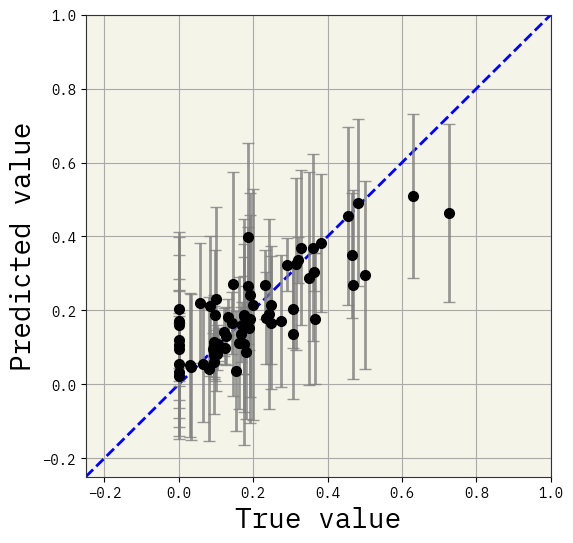

In [121]:
# Cross-validate model
cv = cross_validate(ax_client.generation_strategy.model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()

# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -0.25, 1
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=20)
ax.set_ylabel("Predicted value", fontsize=20)
ax.grid(True)

In [152]:
median_lengthscales = (
    ax_client.generation_strategy.model.model.surrogate.model
    .covar_module.base_kernel.lengthscale
)
print(median_lengthscales)
print(median_lengthscales.argsort())


tensor([[2.1584e-02, 9.8479e+02, 1.4054e+00, 3.9675e-01, 1.8320e+00, 5.4061e+02,
         2.1839e+00, 7.3550e-01, 1.0499e+00, 6.6610e+02]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0, 3, 7, 8, 2, 4, 6, 5, 9, 1]])


## Using the Developer API

### Specify The Loop Ingredients

In [33]:
#optimization_config =  {"f":ObjectiveProperties(minimize=False)}
objective_metric = Metric(name="f", lower_is_better=None)  

### Not sure why i have to do this still. It seems to be a way of handling data communitation between the model and the experiment
class MyRunner(Runner):
    def run(self, trial):
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata

# Define the search space based on the ax_parameters
# Run the cell of search_space above to have the ax_parameters. Is just easier at this point haha
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=param["name"], 
            parameter_type=ParameterType.FLOAT, 
            lower=float(param["bounds"][0]), 
            upper=float(param["bounds"][1])
        )
        if param["type"] == "range" else
        ChoiceParameter(
            name=param["name"],
            values=param["values"],
            parameter_type=ParameterType.FLOAT
        )
        for param in ax_parameters
    ]
)

# Define the experiment with the search space
#the optimization configuration (the objective and metrics)
experiment = Experiment(
    #name="f",
    search_space=search_space,
    optimization_config=OptimizationConfig(objective=Objective(objective_metric, minimize=False)),
    runner=MyRunner(),
)

experiment.warm_start_from_old_experiment(ax_client.generation_strategy.experiment)


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/ax/core/parameter.py:518: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "Nano_stock_vol". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/ax/core/parameter.py:518: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "Nano_stock_vol". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/ax/core/parameter.py:518: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "Ag_acet_conc". Defaulting to `True` for parameters o

[Trial(experiment_name='None', index=0, status=TrialStatus.COMPLETED, arm=Arm(name='0_0', parameters={'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 1.25, 'Time': 60.0, 'Temperature': 25.0})),
 Trial(experiment_name='None', index=1, status=TrialStatus.COMPLETED, arm=Arm(name='1_0', parameters={'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 2.5, 'Time': 60.0, 'Temperature': 25.0})),
 Trial(experiment_name='None', index=2, status=TrialStatus.COMPLETED, arm=Arm(name='2_0', parameters={'Dimension1': 18.8, 'Dimension2': 14.04, 'Dilution(OD)': 0.175, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 5.0, 'Time': 60.0, 'Temperature': 25.0})),
 Trial(experiment_name='None', index=3, status=TrialStatus.COMPLETED, arm=Arm(name='3_0', parameters={'Dimension1': 18.8, 'Dimension2':

### Data


Option 1: If you already went through the Service API part.


In [34]:
ax_client.generation_strategy.experiment.fetch_data().df
data = ax_client.generation_strategy.experiment.fetch_data() 
data.df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,f,0.092522,NaN,0
1,1_0,f,0.047810,NaN,1
2,2_0,f,0.055138,NaN,2
3,3_0,f,0.017066,NaN,3
4,4_0,f,0.019219,NaN,4
...,...,...,...,...,...
56,56_0,f,0.088896,NaN,56
57,57_0,f,0.094812,NaN,57
58,58_0,f,0.117764,NaN,58
59,59_0,f,0.072906,NaN,59


Option 2: If you are only using the Developer API you can add the data manually (learned from https://github.com/facebook/Ax/issues/768)

In [68]:
for i in range(len(modified_features)):
    #parameters
    start_params = {ax_parameters[j]['name']: modified_features.values[i][j] for j in range(9)} #change this accordingly, this is for 9 features ordered as in the search_space defined above (you better run that cell!)
    start_data = Data(
        df=pd.DataFrame.from_records([{"arm_name": f"{i}_0",
                                       "metric_name":"f",
                                       "mean": train_final_label.values[i],
                                       "sem": 0.0,
                                       "trial_index": i}]),
    )
    trial = experiment.new_trial()
    trial.add_arm(Arm(name=f"{i}_0", parameters=start_params))
    experiment.attach_data(start_data)
    trial.run().complete()
    
experiment.fetch_data().df.tail()

,arm_name,metric_name,mean,sem,trial_index
51,51_0,f,0.050798,0.0,51
52,52_0,f,0.045941,0.0,52
53,53_0,f,0.063292,0.0,53
54,54_0,f,0.019460,0.0,54
55,55_0,f,0.049879,0.0,55


### Models and Acquisition Function

In [ ]:
model_bridge_with_GPEI = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=experiment.fetch_data(),                     ###if option 1 for Data uncomment this line
    surrogate=Surrogate(ExactGPModel1,mll_class=LeaveOneOutPseudoLikelihood),
                                   # ),  # Optional, will use default if unspecified
    botorch_acqf_class=qExpectedImprovement,  # Optional, will use default if unspecified
    #transforms=[StandardizeY(), UnitX()],    # Optional, will use default if unspecified (see Transforms documentation)
)


### And get my new experiments! 

In [ ]:
### Assuming the NPL synthesized in the lab has Dimension1 = 27.5728 and Dimension2 = 8.1029
### We can generate a new trial with these values fixed, so that the model can optimize the acquisition function for the remaining variables
Dimension1 = [28.2762,31.1209,19.83495,33.65365,30.5937,29.5289]
Dimension2 = [9.0038,7.35795,14.76195,6.9259,8.8969,8.7368]
for i in range(6):
    generator_run = model_bridge_with_GPEI.gen(n=1,fixed_features=ObservationFeatures({'Dimension1':Dimension1[i],'Dimension2':Dimension2[i]}))
    trial = experiment.new_trial(generator_run=generator_run)
    print(trial.arms[0].parameters)


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



{'Dimension1': 28.2762, 'Dimension2': 9.0038, 'Dilution(OD)': 0.3407447329536081, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 3.5, 'Doping%': 0.5088138650171459, 'Time': 180.0, 'Temperature': 25.0}


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



{'Dimension1': 31.1209, 'Dimension2': 7.35795, 'Dilution(OD)': 0.44796180131379515, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 3.5, 'Doping%': 9.19942325623706, 'Time': 60.0, 'Temperature': 50.0}


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



{'Dimension1': 19.83495, 'Dimension2': 14.76195, 'Dilution(OD)': 0.4187722495989874, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 7.8, 'Doping%': 9.904928831569851, 'Time': 60.0, 'Temperature': 0.0}


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



{'Dimension1': 33.65365, 'Dimension2': 6.9259, 'Dilution(OD)': 0.2559261344745755, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 3.5, 'Doping%': 8.202679619006812, 'Time': 60.0, 'Temperature': 0.0}


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



{'Dimension1': 30.5937, 'Dimension2': 8.8969, 'Dilution(OD)': 0.3130220993142575, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 3.5, 'Doping%': 6.890265372861177, 'Time': 10.0, 'Temperature': 50.0}
{'Dimension1': 29.5289, 'Dimension2': 8.7368, 'Dilution(OD)': 0.4527065884647891, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 14.0, 'Doping%': 8.941820261348038, 'Time': 60.0, 'Temperature': 0.0}


/Users/jorgemedina/Desktop/GroupRetreatWinter2024/BOwithAx/.conda/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning:

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.



In [ ]:
#printing example points here!

Dicts = [{'Dimension1': 28.2762, 'Dimension2': 9.0038, 'Dilution(OD)': 0.4199703258638433, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 6.3735484716860284, 'Time': 60.0, 'Temperature': 25.0},
{'Dimension1': 31.1209, 'Dimension2': 7.35795, 'Dilution(OD)': 0.4199778829724932, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 6.787258467581365, 'Time': 60.0, 'Temperature': 25.0},
{'Dimension1': 19.83495, 'Dimension2': 14.76195, 'Dilution(OD)': 0.161686962165096, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 7.8, 'Doping%': 0.1, 'Time': 60.0, 'Temperature': 25.0},
{'Dimension1': 33.65365, 'Dimension2': 6.9259, 'Dilution(OD)': 0.41998468561511876, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 7.068254874826644, 'Time': 60.0, 'Temperature': 25.0},
{'Dimension1': 30.5937, 'Dimension2': 8.8969, 'Dilution(OD)': 0.4199756072367738, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 6.656585081369508, 'Time': 60.0, 'Temperature': 25.0},
{'Dimension1': 29.5289, 'Dimension2': 8.7368, 'Dilution(OD)': 0.4199738443088641, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 6.533683336863181, 'Time': 60.0, 'Temperature': 25.0}]

#print them nicely in a nice table:
pd.DataFrame(Dicts)

,Dimension1,Dimension2,Dilution(OD),Nano_stock_vol,Ag_acet_conc,Ag_acet_mass,Doping%,Time,Temperature
0,28.27620,9.00380,0.419970,0.50,0.006,14.0,6.373548,60.0,25.0
1,31.12090,7.35795,0.419978,0.50,0.006,14.0,6.787258,60.0,25.0
2,19.83495,14.76195,0.161687,0.25,0.006,7.8,0.100000,60.0,25.0
3,33.65365,6.92590,0.419985,0.50,0.006,14.0,7.068255,60.0,25.0
4,30.59370,8.89690,0.419976,0.50,0.006,14.0,6.656585,60.0,25.0
5,29.52890,8.73680,0.419974,0.50,0.006,14.0,6.533683,60.0,25.0


In [ ]:
trial.run().complete()

Trial(experiment_name='test_f', index=102, status=TrialStatus.COMPLETED, arm=Arm(name='102_0', parameters={'Dimension1': 27.5728, 'Dimension2': 8.1029, 'Dilution(OD)': 0.40492337655113503, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.006, 'Ag_acet_mass': 14.0, 'Doping%': 10.0, 'Time': 60.0, 'Temperature': 50.0}))